# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np
import json

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3


In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"


In [5]:
# Fetch current BTC price
btc_data = requests.get(btc_url).json()
# print(json.dumps(btc_data, indent=4))

# Fetch current ETH price
eth_data = requests.get(eth_url).json()
# print(json.dumps(eth_data, indent=4))

In [6]:
# Compute current value of my crpto
my_btc_value=btc_data["data"]["1"]["quotes"]["USD"]["price"]*my_btc
my_eth_value=eth_data["data"]["1027"]["quotes"]["USD"]["price"]*my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $53118.00
The current value of your 5.3 ETH is $17257.75


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [7]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [8]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Verify that Alpaca key and secret were correctly loaded
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [9]:
# Format current date as ISO format
today = pd.Timestamp("2022-04-01", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_portfolio = alpaca.get_bars(
    tickers,
    timeframe,
    start = today,
    end = today,
    limit=10000
).df


# Separate ticker data
AGG = df_portfolio[df_portfolio['symbol']=='AGG'].drop('symbol', axis=1)
SPY = df_portfolio[df_portfolio['symbol']=='SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
df_portfolio = pd.concat([AGG, SPY], axis=1, keys=['AGG','SPY'])



# Preview DataFrame
df_portfolio.head()

AGG                                    \
                             open    high     low   close    volume   
timestamp                                                             
2022-04-01 04:00:00+00:00  106.35  106.95  106.25  106.75  11579091   

                                                     SPY                  \
                          trade_count        vwap   open    high     low   
timestamp                                                                  
2022-04-01 04:00:00+00:00       40126  106.667931  453.3  453.46  449.14   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2022-04-01 04:00:00+00:00  452.92  88676014      624745  451.850848

In [10]:
# Pick AGG and SPY close prices

#df_closing_prices["AGG"] = df_portfolio["AGG"]["close"]
#df_closing_prices["SPY"] = df_portfolio["SPY"]["close"]

# df_closing_prices["AGG"] = df_portfolio[df_portfolio['symbol']=='AGG'].drop('symbol', axis=1)
# df_closing_prices["SPY"] = df_portfolio[df_portfolio['symbol']=='SPY'].drop('symbol', axis=1)

agg_close_price = float(df_portfolio["AGG"]["close"])
spy_close_price = float(df_portfolio["SPY"]["close"])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $106.75
Current SPY closing price: $452.92


In [11]:
# Compute the current value of shares
my_agg_value = agg_close_price * my_agg
my_spy_value = spy_close_price * my_spy

# Print current value of shares
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")


The current value of your 200 AGG shares is $21350.00
The current value of your 50 SPY shares is $22646.00


### Savings Health Analysis

In [12]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data

#value_data = {
#    "BTC": [my_btc_value],
#    "ETH": [my_eth_value],
#    "AGG": [my_agg_value],
#    "SPY": [my_spy_value]
#}
value_data = {
    "Crypto": [my_btc_value + my_eth_value],
    "Shares": [my_agg_value + my_spy_value]
}   

# Create savings DataFrame
df_savings = pd.DataFrame(data=[my_btc_value + my_eth_value, my_agg_value + my_spy_value], index = ["Crypto", "Shares"], columns=["Amount"], dtype=float)
# Display savings DataFrame
display(df_savings)

,Amount
Crypto,70375.754
Shares,43996.000


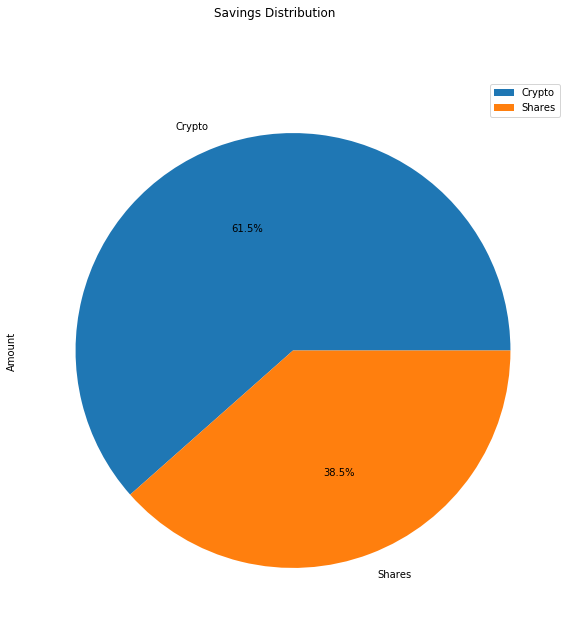

In [13]:
# Plot savings pie chart
df_savings.plot.pie(subplots=True,autopct='%1.1f%%' ,figsize=(20,10),title="Savings Distribution");

In [14]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings.loc["Crypto","Amount"] + df_savings.loc["Shares", "Amount"]

# Validate saving health
if total_savings > emergency_fund:
    print("Congratulations for having enough money in the fund.")
elif total_savings == emergency_fund:
    print("Congratulations on reaching your financial goal")
elif total_savings < emergency_fund:
    print(f"You are {emergency_fund-total_savings} away from reaching your goal!")
else:
    pass

Congratulations for having enough money in the fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [15]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2017-04-04', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-04-04', tz='America/New_York').isoformat()

In [16]:
# Get 5 years' worth of historical data for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_stock_data = alpaca.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
    limit=10000
).df

# Display sample data
df_stock_data

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2017-04-04 04:00:00+00:00,108.61,108.650,108.5200,108.57,1627492,8325,108.591265,AGG
2017-04-05 04:00:00+00:00,108.48,108.740,108.4530,108.69,2304074,11167,108.599103,AGG
2017-04-06 04:00:00+00:00,108.64,108.710,108.4800,108.68,1725301,7746,108.588276,AGG
2017-04-07 04:00:00+00:00,108.80,108.890,108.4200,108.44,1783599,8534,108.645684,AGG
2017-04-10 04:00:00+00:00,108.53,108.650,108.4901,108.58,1903768,12236,108.566615,AGG
...,...,...,...,...,...,...,...,...
2022-03-29 04:00:00+00:00,460.07,462.070,457.1800,461.53,86682895,738526,459.632992,SPY
2022-03-30 04:00:00+00:00,460.29,461.195,456.4650,458.79,79668682,659199,459.158702,SPY
2022-03-31 04:00:00+00:00,457.92,458.760,451.1600,452.11,118607132,751169,455.444107,SPY


In [17]:
# Reorganize the DataFrame

# already seperated the ticker data previously

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([AGG, SPY], axis=1, keys=["AGG","SPY"])

# Display sample data
df_stock_data

AGG                                    \
                             open    high     low   close    volume   
timestamp                                                             
2022-04-01 04:00:00+00:00  106.35  106.95  106.25  106.75  11579091   

                                                     SPY                  \
                          trade_count        vwap   open    high     low   
timestamp                                                                  
2022-04-01 04:00:00+00:00       40126  106.667931  453.3  453.46  449.14   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2022-04-01 04:00:00+00:00  452.92  88676014      624745  451.850848

In [18]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_year_cum = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 1000,
    num_trading_days = 252*30
)


In [19]:
# Printing the simulation input data
MC_thirty_year_cum.portfolio_data.head()

AGG                                    \
                             open    high     low   close    volume   
timestamp                                                             
2022-04-01 04:00:00+00:00  106.35  106.95  106.25  106.75  11579091   

                                                                  SPY          \
                          trade_count        vwap daily_return   open    high   
timestamp                                                                       
2022-04-01 04:00:00+00:00       40126  106.667931          NaN  453.3  453.46   

                                                                             \
                              low   close    volume trade_count        vwap   
timestamp                                                                     
2022-04-01 04:00:00+00:00  449.14  452.92  88676014      624745  451.850848   

                                        
                          daily_return  
timestamp                               
2022-04-01 04:00:00+00:00          NaN

In [20]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_year_cum.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7557,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7558,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7559,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


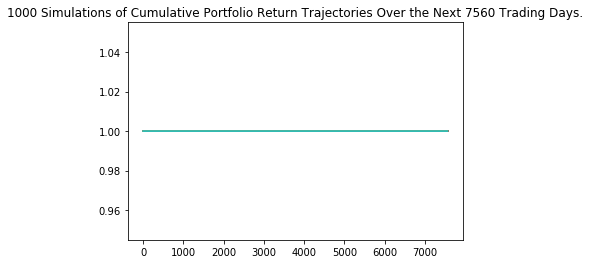

In [21]:
# Plot simulation outcomes
thirty_year_cum_line_plot = MC_thirty_year_cum.plot_simulation()

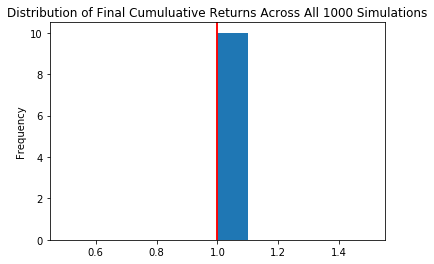

In [22]:
# Plot probability distribution and confidence intervals
thirty_year_cum_dist_plot = MC_thirty_year_cum.plot_distribution()

### Retirement Analysis

In [23]:
# Fetch summary statistics from the Monte Carlo simulation results
thirty_year_cum_tbl = MC_thirty_year_cum.summarize_cumulative_return()

# Print summary statistics
print(thirty_year_cum_tbl)

count           1000.0
mean               1.0
std                0.0
min                1.0
25%                1.0
50%                1.0
75%                1.0
max                1.0
95% CI Lower       1.0
95% CI Upper       1.0
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [24]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]*20000,2)
ci_upper = round(tbl[9]*20000,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

NameError: name 'tbl' is not defined

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [ ]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8]*(20000 * 1.5),2)
ci_upper = round(tbl[9]*(20000 * 1.5),2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns

MC_five_year_cum = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 1000,
    num_trading_days = 252*5
)


# Print the simulation input data
MC_five_year_cum.portfolio_data.head()

In [ ]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_year_cum.calc_cumulative_return()

In [ ]:
# Plot simulation outcomes
five_year_cum_line_plot = MC_five_year_cum.plot_simulation()

In [ ]:
# Plot probability distribution and confidence intervals
five_year_cum_dist_plot = MC_five_year_cum.plot_distribution()

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_cum_tbl = MC_five_year_cum.summarize_cumulative_return()

# Print summary statistics
print(five_year_cum_tbl)

In [ ]:
# Set initial investment
initial_investment = 20000 * 3

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(tbl[8]*(20000 * 3),2)
ci_upper_five = round(tbl[9]*(20000 * 3),2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

### Ten Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns

MC_ten_year_cum = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 1000,
    num_trading_days = 252*10
)

# Print the simulation input data
MC_ten_year_cum.portfolio_data.head()

In [ ]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_year_cum.calc_cumulative_return()

In [ ]:
# Plot simulation outcomes
ten_year_cum_line_plot = MC_ten_year_cum.plot_simulation()

In [ ]:
# Plot probability distribution and confidence intervals
ten_year_cum_dist_plot = MC_ten_year_cum.plot_distribution()

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
ten_year_cum_tbl = MC_ten_year_cum.summarize_cumulative_return()

# Print summary statistics
print(ten_year_cum_tbl)

In [ ]:
# Set initial investment
initial_investment = 20000 * 3

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(tbl[8]*(20000 * 3),2)
ci_upper_ten = round(tbl[9]*(20000 * 3),2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")